In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, utils

from torch.optim import SGD
from torchmetrics import Accuracy

In [7]:
data = pd.read_csv(r"C:\Users\Brand\project_env\PyTorch-Fundamentals\Convolutional-Neural-Network\data\train.csv")
# test_data = pd.read_csv("test.csv")

In [8]:
data["label"]

0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: int64

In [9]:
torch.Tensor(data.drop(columns=["label"]).to_numpy().reshape(42000,1,28,28))[0].shape

torch.Size([1, 28, 28])

In [10]:
class DigitDataset(Dataset):
    def __init__(self, data: pd.DataFrame):
        self.df = data
        self.df_labels = data[["label"]]
        self.df_shape = len(data)
        self.dataset = torch.Tensor(self.df.drop(columns=["label"]).to_numpy().reshape(self.df_shape, 1, 28, 28)).to(torch.float32)
        self.labels = torch.Tensor(self.df_labels.to_numpy()).to(torch.long)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, i):
        return self.dataset[i], self.labels[i]
        

In [20]:
m, _ = data.shape
threshold = 0.6
train_data, test_data = data[0: int(m * 0.6)], data[int(m * 0.6): m]


digit_train_data = DigitDataset(train_data)
digit_test_data = DigitDataset(test_data)

train_dataloader = DataLoader(digit_train_data, batch_size=256, num_workers=1, shuffle=True, drop_last=True)
test_dataloader = DataLoader(digit_test_data, batch_size=256, num_workers=1, shuffle=False, drop_last=True)

# train_feature, train_label = next(iter(train_dataloader))

train_feature, train_label = digit_train_data[1:10]


torch.Size([1, 28, 28])

In [ ]:
def show_image(X: pd.DataFrame, y: pd.DataFrame, title: str, plot_dim: tuple=(4,4),):
    m, _ = X.shape
    height, width = plot_dim
    fig, ax = plt.subplots(height, width, figsize=(16,8))
    fig.suptitle(title)
    
    for i in range(height):
        for j in range(width):
            r_n = np.random.randint(0, m)
            random_img = X.iloc[r_n].to_numpy().reshape(28,28)
            label = y.iloc[r_n]
            
            ax[i, j].set_title(label)
            ax[i, j].imshow(random_img, cmap="gray")
            ax[i, j].axis(False)

def image_dist(X, plot_dim=(4,4)):
    m, _ = X.shape
    height, width = plot_dim
    
    for i in range(height):
        for j in range(width):
            r_n = np.random.randint(0, m)
            random_img = X.iloc[r_n].to_numpy()
            sns.displot(random_img)

In [8]:
X = train_data.drop(labels=["label"], axis=1)
y = train_data["label"]

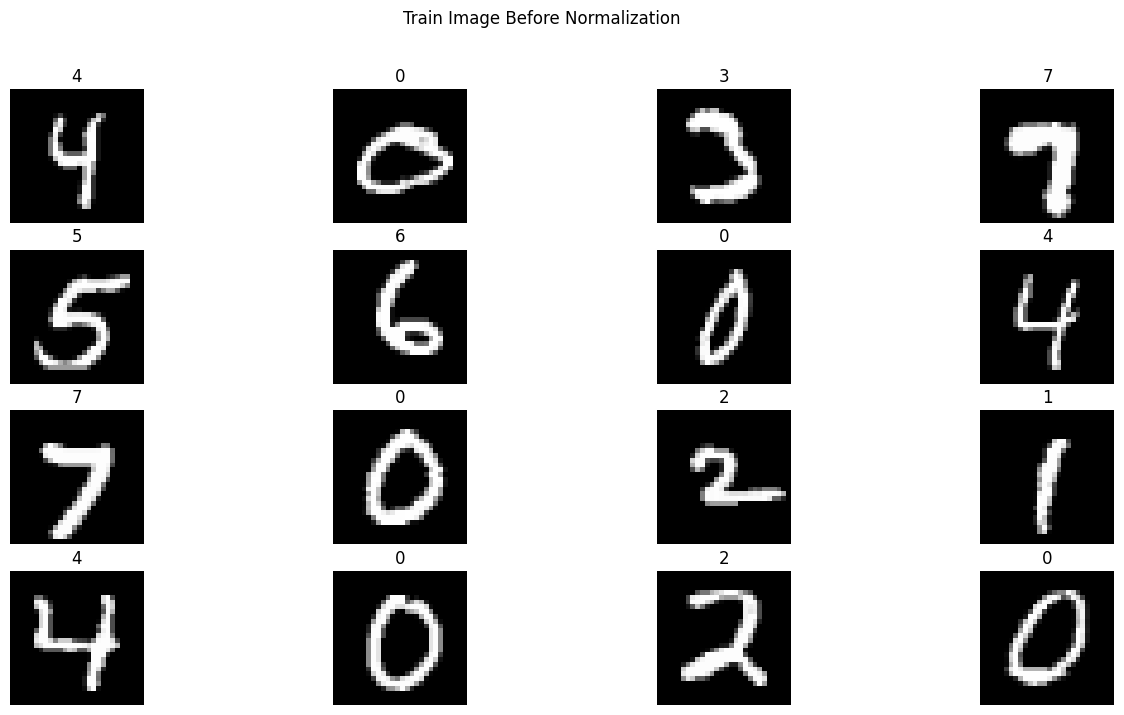

In [9]:
show_image(X, y, "Train Image Before Normalization")

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4, random_state=42)

In [11]:
print(X_train.shape)
X_train.head()

(15120, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
19177,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14483,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4294,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
X_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
312,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5685,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13151,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19357,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
y_train.head()

19177    4
14483    6
4294     1
10422    3
24254    5
Name: label, dtype: int64

In [14]:
y_test.head()

312      2
23478    2
5685     3
13151    2
19357    8
Name: label, dtype: int64

In [15]:
# Normalizing the image for fast training time
X_train /= 255.0
X_test /= 255.0

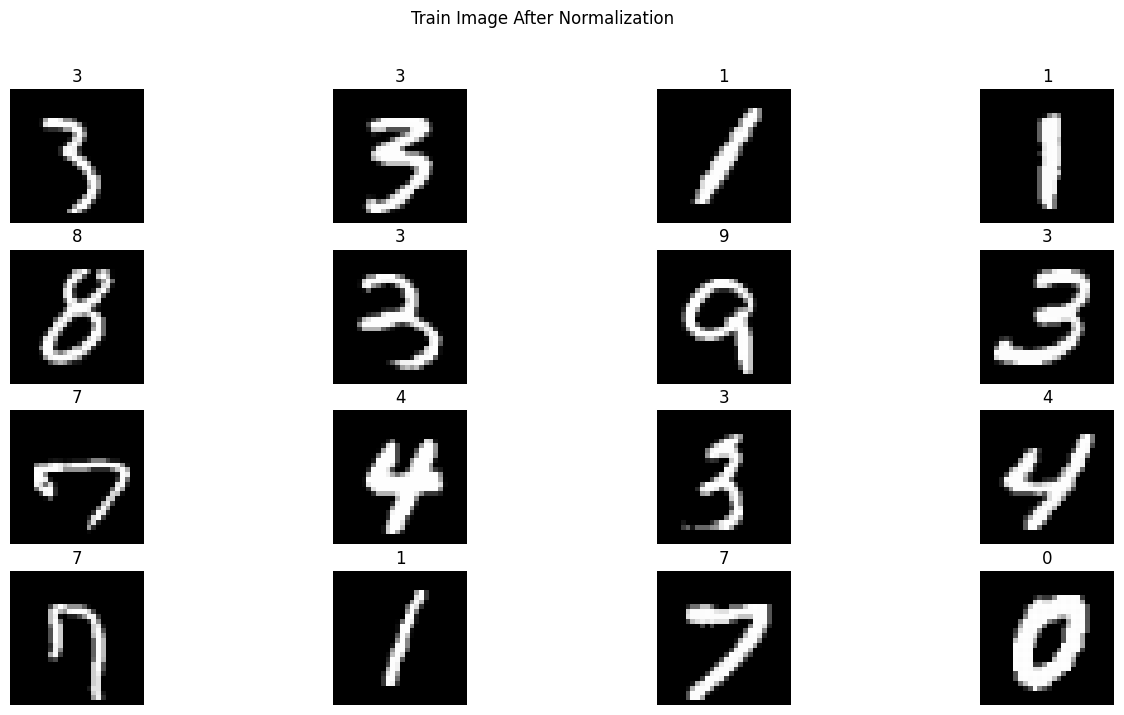

In [16]:
show_image(X_train, y_train, "Train Image After Normalization")

In [20]:
class DigitClassifier(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=6, 
                      kernel_size=(5,5)
                     ),
            nn.ReLU(),
            nn.AvgPool2d(stride=2, 
                         kernel_size=(2,2)),
            
            nn.Dropout2d(p=0.5),
            nn.Conv2d(in_channels=6, 
                      out_channels=16, 
                      kernel_size=(5,5)),
            nn.ReLU(),
            nn.AvgPool2d(stride=2, 
                         kernel_size=(2,2)))
        
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Dropout2d(p=0.5),
            nn.Linear(in_features=256, out_features=120),
            nn.Linear(in_features=120, out_features=84),
            nn.Linear(in_features=84, out_features=output_shape))
    
    def forward(self, x):
        x = self.conv_layer(x)
        return self.fc_layer(x)
    
model = DigitClassifier(1, 10) # image is one channel

In [19]:
from tqdm.auto import tqdm

accuracy = Accuracy(task="multiclass", num_classes=10)
optimizer = SGD(model.parameters(), lr=0.1) # gets the models parameters and does optimization
cross_entropy_loss = nn.CrossEntropyLoss() # loss for multiclassification

def train_test_process(model,
                       train_dataloader, 
                       test_dataloader, 
                       optimizer: SGD, 
                       accuracy_fn: Accuracy, 
                       loss_fn, 
                       epochs: int):
    
    train_losses = []
    test_losses = []
    test_accuracies = []
    
    # sets the model to train mode
    model.train()
    for epoch in tqdm(range(epochs)):

        print(f"Epoch: {epoch}\n-------")
        train_loss = 0
        for batch, (X,y) in enumerate(train_dataloader):

            # forward propogation, gets the predicted y value
            y_pred = model(X)

            # calculates the loss using cross entropy
            loss = loss_fn(y_pred, y)
            train_loss += loss

            # zeros the the gradients from before
            optimizer.zero_grad()

            # goes on to the next 
            loss.backward()
            optimizer.step()

                # Print out how many samples have been seen
            if batch % 400 == 0:
                print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

        train_loss /= len(train_dataloader)

        # sets the model to evaluation mode
        model.eval()
        test_accuracy, test_loss = 0,0

        with torch.inference_mode():
            for X,y in test_dataloader:
                y_pred = model(X)

                test_loss += loss_fn(y_pred, y)
                test_accuracy += accuracy_fn(y, y_pred.argmax(dim=1))

            test_loss /= len(test_dataloader)
            test_accuracy /= len(test_dataloader)
        
        
        train_losses.append(train_loss.detach().numpy())
        test_losses.append(test_loss.detach().numpy())
        test_accuracies.append(test_accuracy.detach().numpy())
        
        print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_accuracy * 100:.2f}%\n")
    
#     return train_losses, test_losses, test_accuracies


In [ ]:
train_test_process(model, train_dataloader, test_dataloader, optimizer, accuracy, cross_entropy_loss, 2)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 0
-------
